### **Evaluating Large Language Models**
For companies integrating large language models (LLMs) into their applications, a systematic approach to model and prompt evaluation is essential. This ensures that they are choosing models optimized for their specific use cases.

A Colab or Jupyter Notebook is a straightforward tool that can be used for generating prediction datasets and conducting thorough evaluations (evals). As new LLMs are released, these notebooks also importantly offer the flexibility to immediately update the prediction datasets and perform evals that cover the new models.

The GENERATE PREDICTIONS section of this notebook outlines the process for generating a dataset of predictions from various models under consideration for use in a medical charting application. This section can be easily updated and rerun as new models are released. The PREDICTION ANALYSIS section contains analysis across several criteria important for this specific use case.


### **Assessing New Models from OpenAI: gpt-4o-mini-2024-07-18 and gpt-4o-2024-08-06**

Before this analysis, I had been using gpt-4o-mini in production with completely satisfactory results. With the release of two new models from OpenAI, I updated the first section of this notebook and reran the evaluations to determine what kinds of improvements, if any, were offered by these models. These systematic evals provided clarity on the following:

- The performance difference between gpt-4o-mini and gpt-4o-mini-2024-07-18.
- The performance difference between gpt-4o and gpt-4o-2024-08-06.
- Whether it would be beneficial to switch from gpt-4o-mini to gpt-4o-mini-2024-07-18 or gpt-4o-2024-08-06.

### **Specific Use Case: Medical Charting Application**


[**soapnotescribe**](https://github.com/josephrmartinez/soapnotescribe) is a web application that utilizes LLMs to automatically generate structured clinical notes from medical appointment recordings.

The application workflow involves first sending the audio of the medical appointment to a speech-to-text model hosted by Replicate. The transcribed text is then processed by a large language model (served by OpenAI or Anthropic) to organize the content into a structured data object, which is subsequently presented to the physician as a SOAP note.

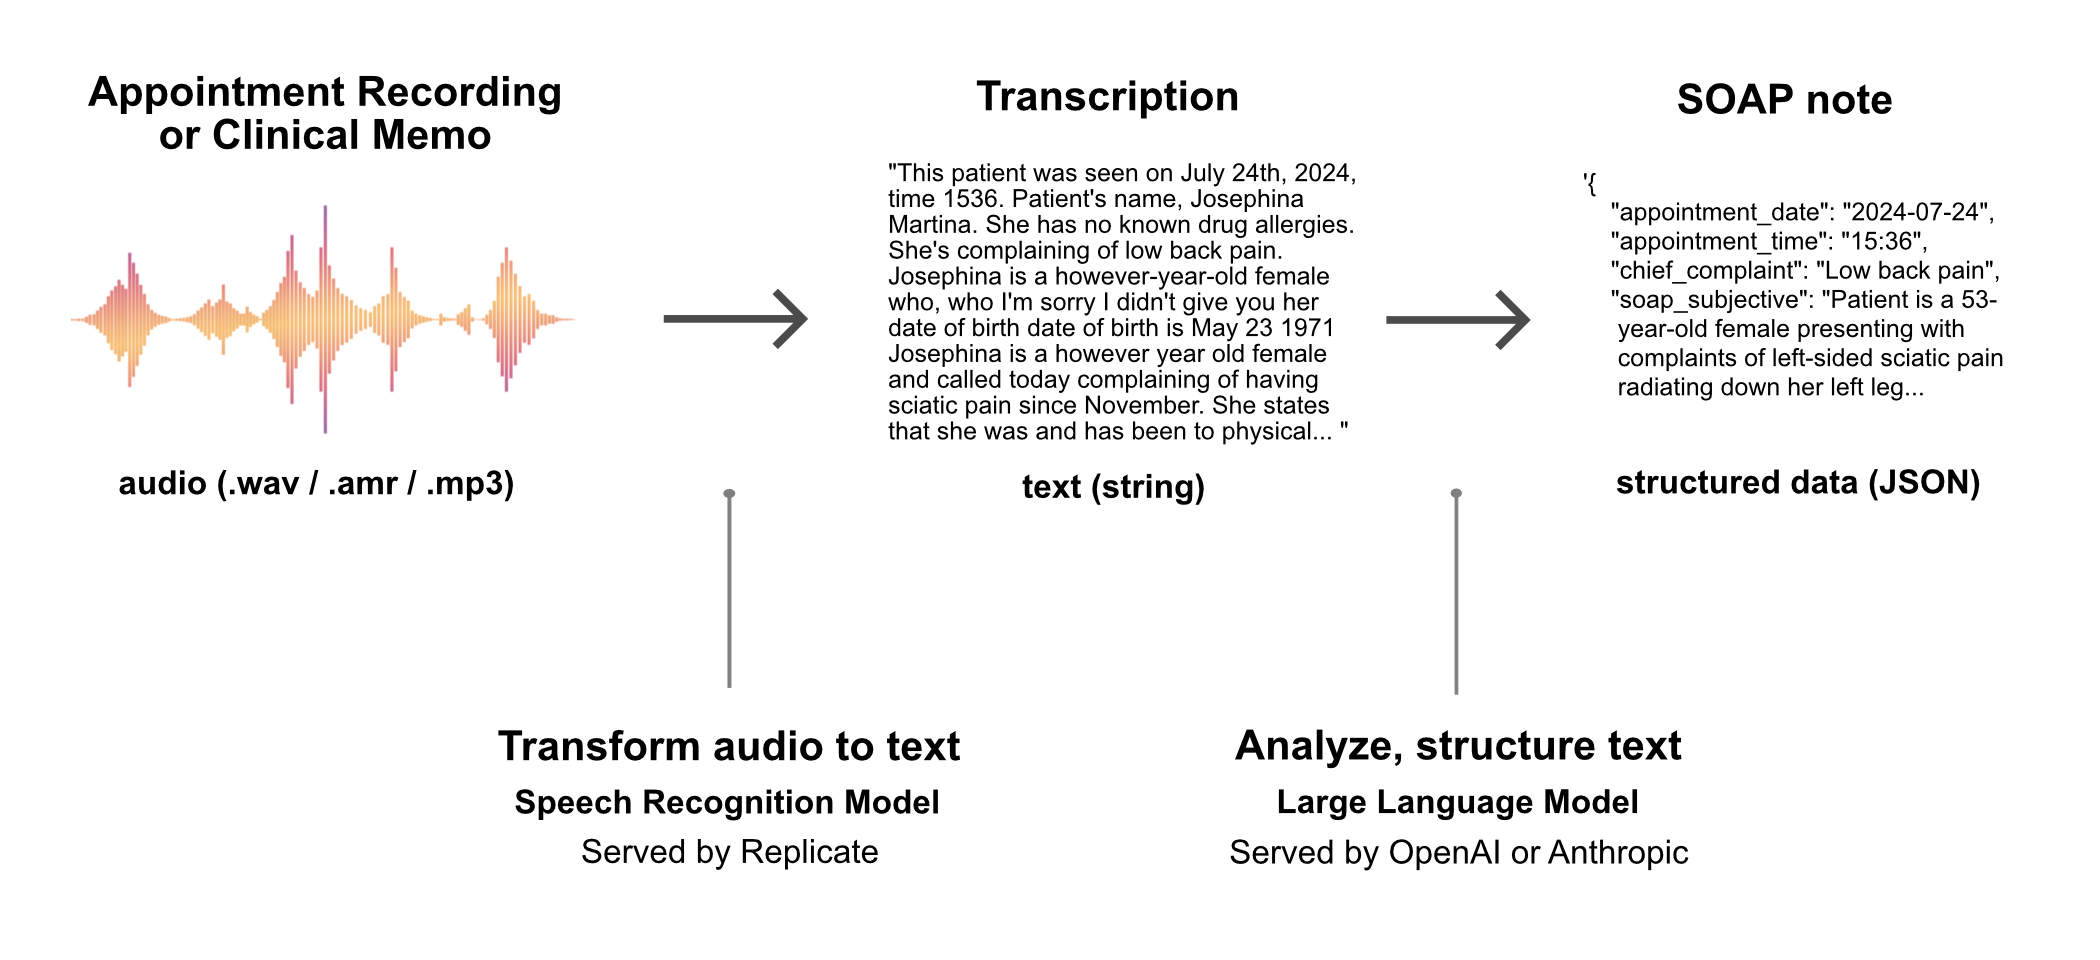

While all major foundational models can generate acceptable SOAP notes from audio transcriptions, they differ significantly in completion times, costs, and quality. Simple pass/fail evaluations are not sufficient to grasp the performance differences of different models under consideration.

The objective of this notebook is to systematically evaluate the performance of models available to convert audio transcriptions into structured SOAP notes and determine whether the application should be updated with one of the newly released models from OpenAI.

Goals:
- **Evaluate Performance for Specific Use Case**: Analyze and measure the performance of different models on key variables.
- **Model Selection**: Choose the optimal model based on a comprehensive evaluation of performance, cost, and suitability for this specific use case.
- **Preparedness for New Models**: Develop a framework for immediate analysis and evaluation when new models are released, enabling a clear understanding of the costs and benefits of switching models.

## **GENERATE PREDICTIONS**

### **Prediction Setup**

In [ ]:
!pip install openai
!pip install anthropic


In [5]:
import os
import time
import json
from openai import OpenAI
import anthropic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [46]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

In [47]:
openai = OpenAI(api_key=OPENAI_API_KEY)
anthropic = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [48]:
# List of common medications. Used to help the LLM correct spelling errors in the transcript.

medications = [
    "Aspirin",
    "Acetaminophen",
    "Ibuprofen",
    "Naproxen",
    "Flexeril",
    "Hydrocodone",
    "Oxycodone",
    "Tramadol",
    "Lidocaine",
    "Epinephrine",
    "Nitroglycerin",
    "Albuterol",
    "Prednisone",
    "Dexamethasone",
    "Amoxicillin",
    "Azithromycin",
    "Cephalexin",
    "Ciprofloxacin",
    "Metronidazole",
    "Clindamycin",
    "Lorazepam",
    "Diazepam",
    "Midazolam",
    "Fentanyl",
    "Morphine",
    "Ondansetron",
    "Promethazine",
    "Diphenhydramine",
    "Hydrocortisone",
    "Ipratropium",
    "Atropine",
    "Naloxone",
    "Flumazenil",
    "Metoprolol",
    "Lisinopril",
    "Losartan",
    "Hydrochlorothiazide",
    "Simvastatin",
    "Warfarin",
    "Heparin",
    "Insulin",
    "Glucagon",
    "Nitrofurantoin",
    "Sulfamethoxazole/Trimethoprim",
    "Chlorhexidine",
    "Ranitidine",
    "Omeprazole",
    "Pantoprazole"
]

In [49]:
# Dictionary storing numbered prompt versions.

system_content_strings = {
    1: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    2: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Correct these errors accurately. Pay special attention to the spelling and formatting of any prescription medications mentioned.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    3: f"""
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Here is a list of common medication names: {medications} . The transcript may include misspellings of these or other medications. Be sure to provide the correct spelling. Correct medication dosage transcriptions by standardizing the format to use a slash ("/") between different ingredient amounts. Convert verbal expressions of dosage, such as "five slash three twenty-five milligrams" or "five milligrams and three hundred twenty-five milligrams," to the format "5/325 milligrams." Ensure the correct separation of amounts and units according to standard prescription practices.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
"""
    }

In [50]:
transcript = """
This patient was seen on July 24th, 2024, time 1536. Patient's name, Josephina Martina. She has no known drug allergies. She's complaining of low back pain. Josephina is a however-year-old female who, who I'm sorry I didn't give you her date of birth date of birth is May 23 1971 Josephina is a however year old female and called today complaining of having sciatic pain since November. She states that she was and has been to physical therapy she was doing better however it has worsened recently causing her to have left left-sided sciatic pain radiating down her left leg she reports of pain as being constant she denies any red flags such as saddle anesthesia, loss of urine or bowel control, and she denies having any weakness to the extremity. prescribed physical therapy, but no other workup for her. She has not had an MRI of her lumbar spine. She is on tenazidine for migraine headaches, but is not on any medication for this. She calls today with an acute flare-up and is requesting to be treated for it until she can get in to see her primary care doctor she denies any abdominal pain dysuria or hematuria she sees she's otherwise healthy she has no known drug allergies and no significant medical problems except for the migraine headaches. Based on her symptomatology and the fact that she is young and otherwise healthy, I will treat her for acute sciatica with lumbar go, but I have recommended that she undergo an MRI of her lumbar spine if she has not had any imaging as she may have a ruptured disc, nerve impingement, or degenerative disc disease. Her diagnosis is acute lumbar go with left-sided sciatica the plan is I have prescribed a medull dose pack to be dispensed per pharmacist no refill flexor all 20 milligram tablets used to take one POB ID PRN muscle spasm and Vicodin 5-3, 25 milligrams. She used to take one to two POQ, four to six hours, PRN pain, dispense 20, no refill."""

In [51]:
user_content_string = f"""
Give me a thorough SOAP note from the following transcript. Return your response as a JSON object. /// TRANSCRIPT: {transcript} """

In [2]:
# Add new models to model list:
openai_models = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini', 'gpt-4o-mini-2024-07-18', 'gpt-4o-2024-08-06', ]

In [54]:
openai_temperatures = [1]

In [55]:
anthropic_models = ['claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620']

In [56]:
anthropic_temperatures = [1]

In [57]:
iterations = 10

In [58]:
# Add new models to model_pricing dictionary:

model_pricing = {
    "gpt-4-turbo": {
        "input_token_cost": 0.01,
        "output_token_cost": 0.03
    },
    "gpt-4o": {
        "input_token_cost": 0.005,
        "output_token_cost": 0.015
    },
    "gpt-4o-2024-08-06": {
        "input_token_cost": 0.00250,
        "output_token_cost": 0.01
    },
    "gpt-4o-mini": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-4o-mini-2024-07-18": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-3.5-turbo": {
        "input_token_cost": 0.0005,
        "output_token_cost": 0.0015
    },
    "claude-3-haiku-20240307": {
        "input_token_cost": 0.00025,
        "output_token_cost": 0.00125
    },
    "claude-3-5-sonnet-20240620": {
        "input_token_cost": 0.003,
        "output_token_cost": 0.015
    },
    "claude-3-opus-20240229": {
        "input_token_cost": 0.015,
        "output_token_cost": 0.075
    }
}

**Ensuring Consistent JSON Outputs from LLMs with Tool Calling**

When using LLMs to convert unstructured data into structured data, defining a JSON schema is essential. While OpenAI and Anthropic provide a "JSON mode," it only ensures the output is valid JSON, not that it adheres to a specific schema.

To enforce a specific JSON schema, you must define it in the tool_choice parameter (as OpenAI has deprecated function calling). Avoid placing the schema in the system prompt.

The examples below demonstrate how to properly define a JSON schema and use it within the tool calling feature for both OpenAI and Anthropic.

**Note on Structured Outputs Feature**

On August 6, 2024, OpenAI introduced the Structured Outputs feature: [Structured Outputs Announcement](https://openai.com/index/introducing-structured-outputs-in-the-api/).

This feature improves upon JSON mode by ensuring responses adhere to developer-supplied JSON schemas. However, the Structured Outputs feature does not currently support certain keywords like pattern, format, and maxLength. For applications using JSON schemas with these keywords, it is necessary to continue using tool calling for now.

In [59]:
JSON_schema_tool_calling = {
          "type": "object",
          "properties": {
            "appointment_date": {
              "type": "string",
              "format": "date",
              "pattern": "^\\d{4}-\\d{2}-\\d{2}$",
              "description": "Date of the appointment in yyyy-mm-dd format"
            },
            "appointment_time": {
              "type": "string",
              "pattern": "^\\d{2}:\\d{2}$",
              "description": "Time of the appointment in hh:mm format"
            },
            "chief_complaint": {
              "type": "string",
              "maxLength": 50,
              "description": "Chief complaint. Capitalize the first letter of the string"
            },
            "soap_subjective": {
              "type": "string",
              "description": "Subjective information from the patient. DO NOT include patient name or date of birth."
            },
            "soap_objective": {
              "type": "string",
              "description": "Objective observations and measurements. Narrative format or UNORDERED list. DO NOT include patient name or date of birth."
            },
            "soap_assessment": {
              "type": "string",
              "description": "Assessment and diagnosis. Narrative format or UNORDERED list. NO DIFFERENTIAL DIAGNOSIS in this field."
            },
            "soap_plan": {
              "type": "string",
              "description": "Plan for treatment and patient education. Be sure to correct spelling and formatting of medications. Narrative format or UNORDERED list."
            },
            "differential_diagnosis": {
              "type": "string",
              "description": "Differential diagnosis. Always include alternative treatment options. Narrative format or UNORDERED list."
            },
            "patient_location": {
              "type": "string",
              "description": "Location of the patient (State/Province, e.g., 'Arizona'). Only include this key if the patient location is clearly mentioned in the transcript."
            }
          }
        }

In [60]:
#OpenAI API prediction request:

def get_analysis_openai(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_openai with model: {model}")
    start_time = time.time()

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content_string},
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            response_format={"type": "json_object"},
            tools=[{
                "type": "function",
                "function": {
                    "name": "JSON_soap_note",
                    "description":"Clinical SOAP note as a JSON object",
                    "parameters": JSON_schema_tool_calling
                }
            }],
            tool_choice={"type": "function", "function": {"name": "JSON_soap_note"}},
        )

        completion_string = response.choices[0].message.tool_calls[0].function.arguments
        usage = response.usage

        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': completion_string,
            'prompt_version': prompt_version
        }

        # Parse completion string
        try:
            completion_data = json.loads(completion_string)
            response_data.update(completion_data)
        except json.JSONDecodeError:
            pass

        return response_data



    except Exception as e:
        print("Error getting OpenAI completion data:", e)
        return {'error': str(e)}

In [63]:
#Anthropic API prediction request:

def get_analysis_anthropic(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_anthropic with model: {model}")
    start_time = time.time()

    try:
        response = anthropic.messages.create(
            model=model,
            messages=[
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            system=system_content_string,
            max_tokens=4096,
            tool_choice={"type": "tool", "name":"JSON_soap_note"},
            tools=[{
                "name": "JSON_soap_note",
                "description":"Clinical SOAP note as a JSON object",
                "input_schema": JSON_schema_tool_calling
                }]
        )

        tool_use_block = response.content[0]

        soap_note = tool_use_block.input

        usage = response.usage
        input_tokens = usage.input_tokens
        output_tokens = usage.output_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': json.dumps(soap_note),
            'prompt_version': prompt_version
        }

        response_data.update(soap_note)


        return response_data

    except Exception as e:
        print("Error getting Anthropic completion data:", e)
        return {'error': str(e)}

### **Get Predictions**

In [62]:
# Test OpenAI API prediction once:

model='gpt-4o-mini-2024-07-18'
temperature = 1
prompt_version = 3
system_content_string = system_content_strings[prompt_version]

result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
print(result)


calling get_analysis_openai with model: gpt-4o-mini-2024-07-18
{'model': 'gpt-4o-mini-2024-07-18', 'temperature': 1, 'input_tokens': 1348, 'output_tokens': 373, 'input_cost': 0.00015, 'output_cost': 0.0006, 'prediction_cost': 0.000426, 'prediction_time': 4.768899202346802, 'completion_string': '{"appointment_date":"2024-07-24","appointment_time":"15:36","chief_complaint":"Low back pain","soap_subjective":"Josephina Martina, a female born on May 23, 1971, presents with a complaint of left-sided sciatic pain radiating down her left leg that began in November. She reports that the pain has been constant and has worsened recently, although she previously improved with physical therapy. She denies any red flags such as saddle anesthesia, loss of bladder or bowel control, or extremity weakness. Josephina does not report abdominal pain, dysuria, or hematuria, and she states she is otherwise healthy, aside from migraine headaches for which she takes tenazidine.","soap_objective":"- Patient is 

In [ ]:
# Get predictions for each OpenAI model:

results_openai = []

prompt_version = 3
system_content_string = system_content_strings[prompt_version]

for model in openai_models:
    for temperature in openai_temperatures:
        for _ in range(iterations):
            result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)



In [64]:
# Test Anthropic API prediction once:

model = 'claude-3-haiku-20240307'
temperature = 1
prompt_version = 3
system_content_string = system_content_strings[prompt_version]

result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature, prompt_version)

print(result)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
{'model': 'claude-3-haiku-20240307', 'temperature': 1, 'input_tokens': 2028, 'output_tokens': 605, 'input_cost': 0.00025, 'output_cost': 0.00125, 'prediction_cost': 0.00126325, 'prediction_time': 3.9452404975891113, 'completion_string': '{"appointment_date": "2024-07-24", "appointment_time": "15:36", "chief_complaint": "Low back pain", "differential_diagnosis": "- Ruptured intervertebral disc\\n- Lumbar radiculopathy\\n- Degenerative disc disease\\nAlternative treatment options include physical therapy, epidural steroid injections, and surgical decompression if conservative management fails.", "patient_location": "Unknown", "soap_assessment": "Acute lumbar radiculopathy with left-sided sciatica, likely due to a disc herniation or degenerative disc disease. The patient has not had any imaging studies to confirm the diagnosis, but her symptoms and presentation are consistent with a lumbar radiculopathy.", "soap_objective"

In [ ]:
# Get predictions for each Anthropic model:

results_anthropic = []

prompt_version = 3
system_content_string = system_content_strings[prompt_version]

for model in anthropic_models:
    for temperature in anthropic_temperatures:
        for _ in range(iterations):
            result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature, prompt_version)
            if result:
                results_anthropic.append(result)

# Convert results to a DataFrame
df_results_anthropic = pd.DataFrame(results_anthropic)

# Save to csv
if os.path.exists('results-anthropic.csv'):
    df_results_anthropic.to_csv('results-anthropic.csv', mode='a', header=False, index=False)
else:
    df_results_anthropic.to_csv('results-anthropic.csv', index=False)

## **EVALUATE PREDICTIONS**

**Model currently used in production:** gpt-4o-mini

**Models previously evaluated:**
- gpt-3.5-turbo
- gpt-4o
- gpt-4o-mini
- claude-3-haiku-20240307
- claude-3-5-sonnet-20240620

**New models evaluated:**
- gpt-4o-mini-2024-07-18
- gpt-4o-2024-08-06

This notebook makes it simple to perform some standard evaluations on each model:
- Cost
- Speed (Response Time)
- Prediction Length (output tokens)

We can also set up some evaluations that are specific to this particular use case:
- Length of differential diagnosis field.
- Inclusion of alternative treatment plan in differential diagnosis.
- Correction of medication spelling errors from transcript.
- Correction of medication formatting errors from transcript.


In [1]:
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load csv file with combined results of new predictions with previous predictions
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/soapnotescribe/model_evals_2024_08_09.csv')


Mounted at /content/drive


### **Analysis: Prediction Time**
How long does it take for each model to return a response? Note that for some applications the variability of response times may be an important consideration. This dataset shows that some models are much more consistent in their response times than others.  

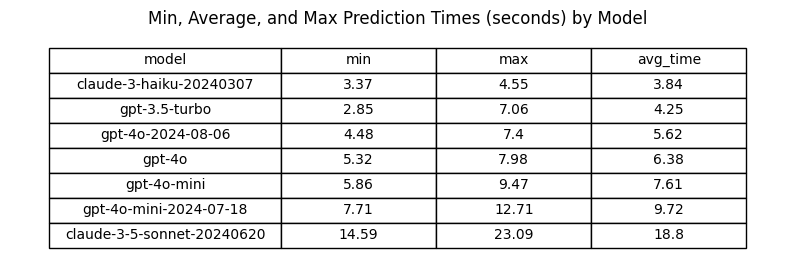

In [48]:
avg_time = df.groupby('model')['prediction_time'].mean().reset_index(name='avg_time')

grouped_time = df.groupby('model')['prediction_time'].agg(['min', 'max']).reset_index()
grouped_time = pd.merge(grouped_time, avg_time, left_on='model', right_on='model')

grouped_time = grouped_time.sort_values(by='avg_time', ascending=True)

# print(grouped_time.to_string(index=False))

# Plotting the table as an image
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust size to fit table
ax.axis('off')

# Set specific column widths (first column wider, others narrower)
col_widths = [0.3, 0.2, 0.2, 0.2]  # Adjust these values as needed

table = ax.table(
    cellText=grouped_time.round(2).values,
    colLabels=grouped_time.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths
)

ax.set_title('Min, Average, and Max Prediction Times (seconds) by Model')

table.auto_set_font_size(False)
table.scale(1, 1.5)

plt.show()


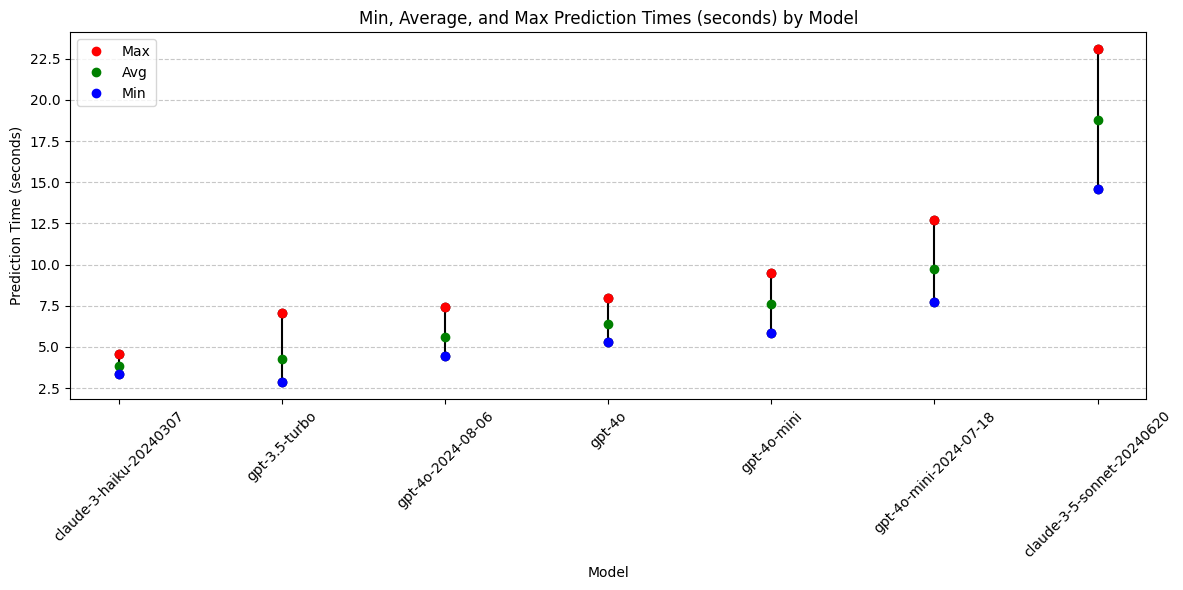

In [5]:
plt.figure(figsize=(12, 6))

for i, row in grouped_time.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_time'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Min, Average, and Max Prediction Times (seconds) by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
# Function to calculate absolute and relative differences of avg prediction times between two models

def calculate_avg_time_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_time1 = df1['prediction_time'].mean()
    avg_time2 = df2['prediction_time'].mean()

    absolute_difference = avg_time1 - avg_time2
    relative_difference = (absolute_difference / avg_time2) * 100 if avg_time1 != 0 else float('inf')  # Avoid division by zero

    # Format the results
    result = (f"{model1} avg prediction time: {avg_time1:.2f} seconds\n"
              f"{model2} avg prediction time: {avg_time2:.2f} seconds\n"
              f"Absolute difference: {absolute_difference:.2f} seconds\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [7]:
# Calculate prediction time difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_time_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg prediction time: 9.72 seconds
gpt-4o-mini avg prediction time: 7.61 seconds
Absolute difference: 2.11 seconds
Relative difference: 27.72%


In [8]:
# Calculate prediction time difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_time_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg prediction time: 5.62 seconds
gpt-4o avg prediction time: 6.38 seconds
Absolute difference: -0.77 seconds
Relative difference: -12.01%


#### **Conclusions: Prediction Time**

- gpt-4o-mini-2024-07-18 predictions take about 2.1 seconds (28%) longer on average than gpt-4o-mini predictions

- gpt-4o-2024-08-06 predictions take about 0.77 seconds (12%) less time on average than gpt-4o predictions.

- Prediction time is not the most important criteria for this use-case, but getting predictions in under ten seconds is desirable. For this reason, switching from gpt-4o-mini to gpt-4o-mini-2024-07-18 does not look advantageous.  

**Top Models for Prediction Speed and Consistency:**
1. claude-3-haiku (reliably under 5 seconds)
2. gpt-3.5-turbo
3. gpt-4o-2024-08-06

### **Analysis: Prediction Cost**

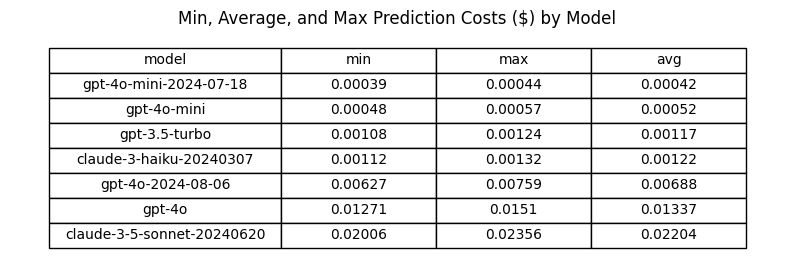

In [50]:
# Calculate average cost, grouping by model
avg_cost = df.groupby(['model'])['prediction_cost'].mean().reset_index(name='avg')

# Calculate min and max costs, grouping by model
grouped_cost = df.groupby(['model'])['prediction_cost'].agg(['min', 'max']).reset_index()

# Merge the grouped cost with the average cost
grouped_cost = pd.merge(grouped_cost, avg_cost, on=['model'])

# Sort the DataFrame by avg cost in ascending order
grouped_cost = grouped_cost.sort_values(by='avg', ascending=True)

# Plotting the table as an image
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust size to fit table
ax.axis('off')

# Set specific column widths (first column wider, others narrower)
col_widths = [0.3, 0.2, 0.2, 0.2]  # Adjust these values as needed

table = ax.table(
    cellText=grouped_cost.round(5).values,
    colLabels=grouped_cost.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths
)

table.auto_set_font_size(False)
table.scale(1, 1.5)

ax.set_title('Min, Average, and Max Prediction Costs ($) by Model')

plt.show()


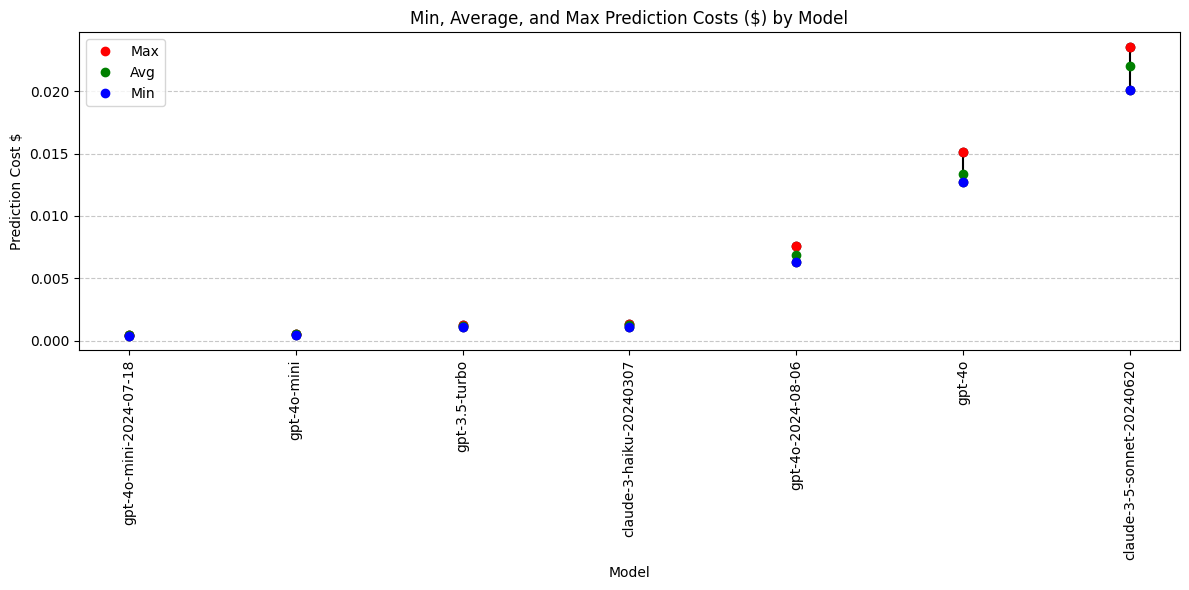

In [17]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
# Function to calculate absolute and relative differences of avg cost between two models

def calculate_avg_cost_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_output1 = df1['prediction_cost'].mean()
    avg_output2 = df2['prediction_cost'].mean()

    absolute_difference = avg_output1 - avg_output2
    relative_difference = (absolute_difference / avg_output2) * 100

    # Format the results
    result = (f"{model1} avg prediction cost: ${avg_output1:.5f}\n"
              f"{model2} avg prediction cost: ${avg_output2:.5f}\n"
              f"Absolute difference: {absolute_difference:.5f}\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [19]:
# Calculate prediction cost difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_cost_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg prediction cost: $0.00688
gpt-4o avg prediction cost: $0.01337
Absolute difference: -0.00648
Relative difference: -48.51%


In [20]:
# Calculate prediction cost difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_cost_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg prediction cost: $0.00042
gpt-4o-mini avg prediction cost: $0.00052
Absolute difference: -0.00011
Relative difference: -20.37%


#### **Conclusions: Prediction Cost**
- gpt-4o-2024-08-06 has a 48.5% lower average prediction cost compared to gpt-4o.
- gpt-4o-mini-2024-07-18 has a 20.4% lower average prediction cost compared to gpt-4o-mini.
- gpt-4o-mini-2024-07-18 is now the least expensive model.


**Models with lowest cost:**
1. gpt-4o-mini-2024-07-18
2. gpt-4o-mini

### **Analysis: Output Tokens**

Which models are more or less verbose?


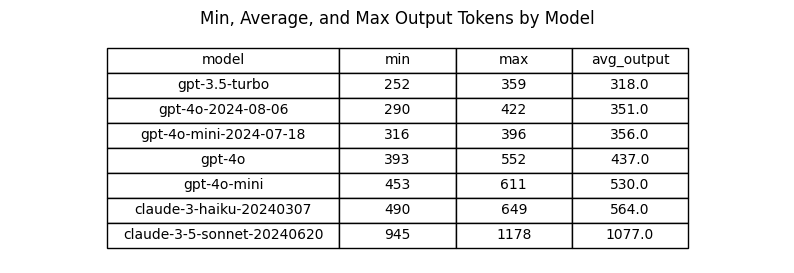

In [51]:
# Exclude claude-3-opus model
#df = df.loc[df['model'] != 'claude-3-opus-20240229']

avg_output_tokens = df.groupby(['model'])['output_tokens'].mean().reset_index(name='avg_output')

grouped_output = df.groupby(['model'])['output_tokens'].agg(['min', 'max']).reset_index()
grouped_output = pd.merge(grouped_output, avg_output_tokens, on=['model'])

grouped_output = grouped_output.sort_values(by=['model'])

grouped_output = grouped_output.sort_values(by='avg_output')

# Plotting the table as an image
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust size to fit table
ax.axis('off')

# Set specific column widths (first column wider, others narrower)
col_widths = [0.3, 0.15, 0.15, 0.15]  # Adjust these values as needed

table = ax.table(
    cellText=grouped_output.round(0).values,
    colLabels=grouped_output.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths,
)

ax.set_title('Min, Average, and Max Output Tokens by Model')

table.auto_set_font_size(False)
table.scale(1, 1.5)

plt.show()


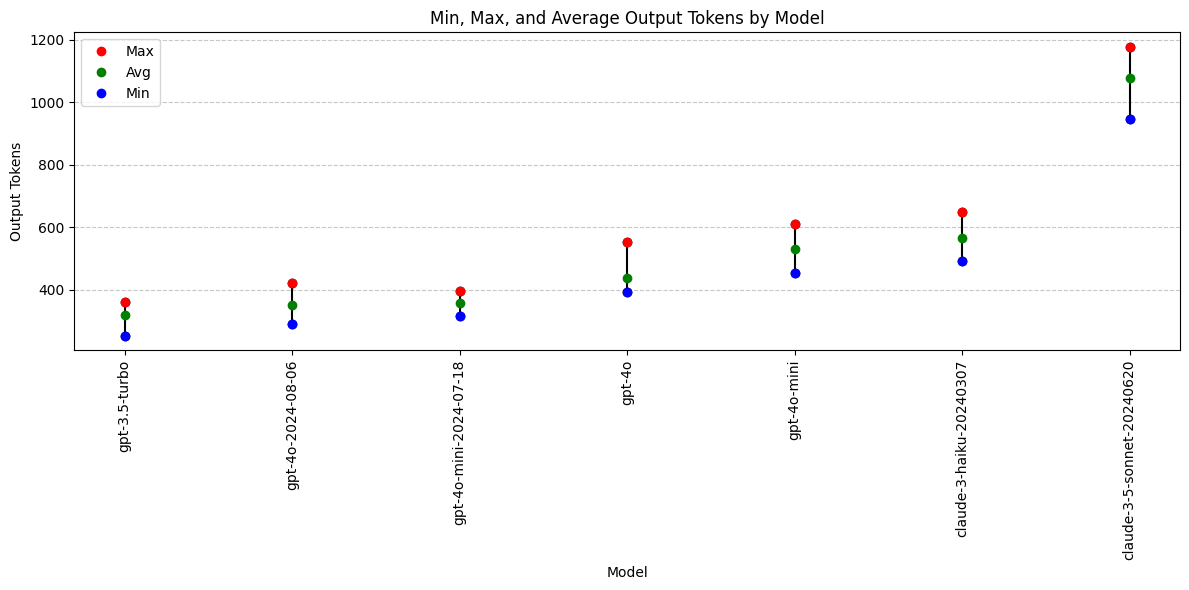

In [67]:
plt.figure(figsize=(12, 6))

for i, row in grouped_output.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_output'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Output Tokens')
plt.title('Min, Max, and Average Output Tokens by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [68]:
# Function to calculate absolute and relative differences of avg output tokens between two models

def calculate_avg_output_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    avg_output1 = df1['output_tokens'].mean()
    avg_output2 = df2['output_tokens'].mean()

    absolute_difference = avg_output1 - avg_output2
    relative_difference = (absolute_difference / avg_output2) * 100

    # Format the results
    result = (f"{model1} avg output tokens: {avg_output1:.2f} tokens\n"
              f"{model2} avg output tokens: {avg_output2:.2f} tokens\n"
              f"Absolute difference: {absolute_difference:.2f} tokens\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [69]:
# Calculate output token difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_output_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg output tokens: 351.40 tokens
gpt-4o avg output tokens: 436.90 tokens
Absolute difference: -85.50 tokens
Relative difference: -19.57%


In [70]:
# Calculate output token difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_output_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg output tokens: 356.30 tokens
gpt-4o-mini avg output tokens: 529.90 tokens
Absolute difference: -173.60 tokens
Relative difference: -32.76%


####**Conclusions: Output Tokens**
- The new models from OpenAI appear to be less verbose than their counterpart models.
  - gpt-4o-2024-08-06 returns about 20% less tokens than gpt-4o
  - gpt-4o-mini-2024-07-18 returns about 33% less tokens than gpt-4o-mini
- This less verbose behavior may not be advantageous. Brevity is not nessesarily preferred for this use case.
- Anthropic's Claude models generally produce more verbose outputs compared to OpenAI's GPT models.
  - claude-3-5-sonnet is an outlier in output token length.


**Models with output token preference:**
- Not applicable. Longer/shorter is not necessarily better.

### **Analysis: Differential Diagnosis**
- Was a Differential Diagnosis returned? If so, what was the average length?
- How many Differential Diagnosis values included "alternative treatments" as requested in the system prompt?

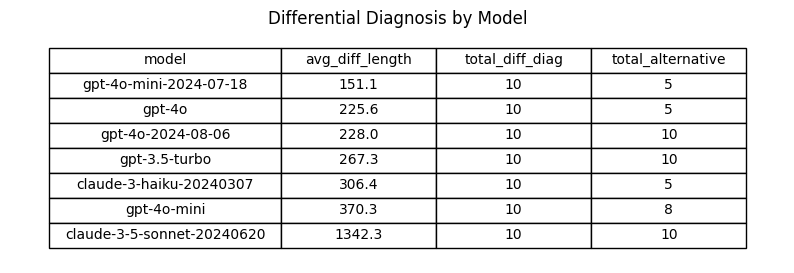

In [60]:
# Function to calculate the length of differential diagnosis or zero if empty
def diagnosis_length(diagnosis: str):
    return len(diagnosis) if diagnosis else 0

df['differential_diagnosis'] = df['differential_diagnosis'].fillna('')

# Add a new column for the length of differential diagnosis
df['diff_diag_length'] = df['differential_diagnosis'].apply(diagnosis_length)

# Count the number of rows with a non-empty differential diagnosis
df['has_diff_diag'] = df['differential_diagnosis'].apply(lambda x: 1 if x else 0)

# Check if 'alternative' is in the differential diagnosis
df['has_alternative'] = df['differential_diagnosis'].apply(lambda x: 1 if 'alternative' in x.lower() else 0)

# Calculate the average length of differential diagnosis
avg_diff_length = df.groupby(['model'])['diff_diag_length'].mean().reset_index(name='avg_diff_length')

# Count the number of rows with a non-empty differential diagnosis
total_diff_diag = df.groupby(['model'])['has_diff_diag'].sum().reset_index(name='total_diff_diag')

# Count the number of rows with 'alternative' in the differential diagnosis
total_alternative = df.groupby(['model'])['has_alternative'].sum().reset_index(name='total_alternative')

# Merge the results
grouped_output = pd.merge(avg_diff_length, total_diff_diag, on=['model'])
grouped_output = pd.merge(grouped_output, total_alternative, on=['model'])

# Sort the DataFrame by avg_diff_length in ascending order
grouped_output = grouped_output.sort_values(by='avg_diff_length', ascending=True)

# Plotting the table as an image
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust size to fit table
ax.axis('off')

# Set specific column widths (first column wider, others narrower)
col_widths = [0.3, 0.2, 0.2, 0.2]  # Adjust these values as needed

table = ax.table(
    cellText=grouped_output.values,
    colLabels=grouped_output.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths,
)

ax.set_title('Differential Diagnosis by Model')

table.auto_set_font_size(False)
table.scale(1, 1.5)

plt.show()

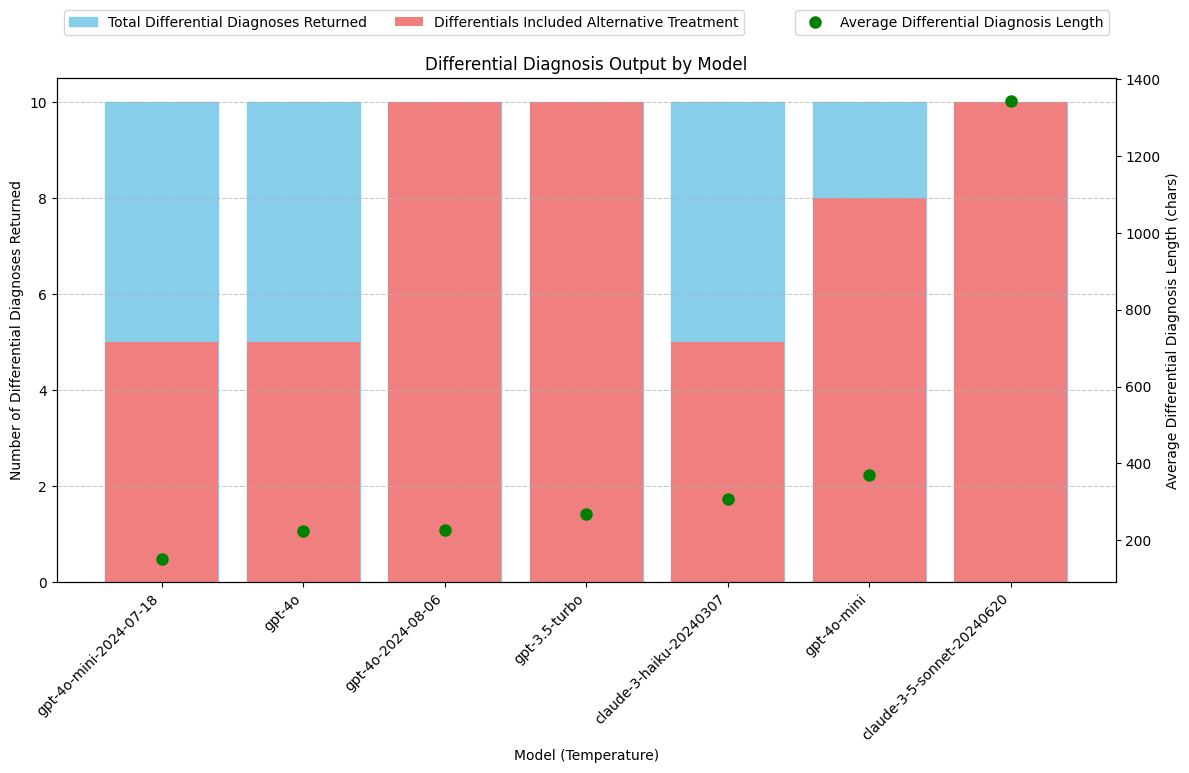

In [64]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for total differentials
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_diff_diag'], label='Total Differential Diagnoses Returned', color='skyblue', edgecolor='skyblue')

# Bar chart for differentials that include "alternative"
bar2 = ax1.bar(grouped_output['model'], grouped_output['total_alternative'], label='Differentials Included Alternative Treatment', color='lightcoral')

# Secondary y-axis for average differential diagnosis length
ax2 = ax1.twinx()
ax2.plot(grouped_output['model'], grouped_output['avg_diff_length'], color='green', marker='o', linestyle='', linewidth=2, markersize=8, label='Average Differential Diagnosis Length')

# Customizing the plot
ax1.set_xlabel('Model (Temperature)')
ax1.set_ylabel('Number of Differential Diagnoses Returned')
ax2.set_ylabel('Average Differential Diagnosis Length (chars)')
ax1.set_title('Differential Diagnosis Output by Model')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=45, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [65]:
# Function to calculate absolute and relative differences of avg differential diagnosis length between two models

def calculate_avg_differential_difference(df: pd.DataFrame, model1: str, model2: str) -> float:
    # Retrieve avg_diff_length for each model
    avg_diff_length1 = grouped_output.loc[grouped_output['model'] == model1, 'avg_diff_length'].values[0]
    avg_diff_length2 = grouped_output.loc[grouped_output['model'] == model2, 'avg_diff_length'].values[0]

    absolute_difference = avg_diff_length1 - avg_diff_length2
    relative_difference = (absolute_difference / avg_diff_length2) * 100

    # Format the results
    result = (f"{model1} avg length of differential diagnosis: {avg_diff_length1:.2f} chars\n"
              f"{model2} avg length of differential diagnosis: {avg_diff_length2:.2f} chars\n"
              f"Absolute difference: {absolute_difference:.2f} chars\n"
              f"Relative difference: {relative_difference:.2f}%")

    return result

In [66]:
# Calculate differential diagnosis length difference between 'gpt-4o-2024-08-06' and 'gpt-4o':
difference = calculate_avg_differential_difference(df, 'gpt-4o-2024-08-06', 'gpt-4o' )
print(difference)

gpt-4o-2024-08-06 avg length of differential diagnosis: 228.00 chars
gpt-4o avg length of differential diagnosis: 225.60 chars
Absolute difference: 2.40 chars
Relative difference: 1.06%


In [67]:
# Calculate differential diagnosis length difference between 'gpt-4o-mini-2024-07-18' and 'gpt-4o-mini':
difference = calculate_avg_differential_difference(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini' )
print(difference)

gpt-4o-mini-2024-07-18 avg length of differential diagnosis: 151.10 chars
gpt-4o-mini avg length of differential diagnosis: 370.30 chars
Absolute difference: -219.20 chars
Relative difference: -59.20%


####**Conclusions: Differential Diagnosis**

The claude-3-5-sonnet model is an outlier with Differential Diagnosis outputs that are 3 to 5 times longer than those of other models. Manual review indicates that these longer outputs are of high quality and significantly enrich the SOAP notes.

**gpt-4o-2024-08-06**
- gpt-4o-2024-08-06 returns a differrential about the same length as gpt-4o
- gpt-4o-2024-08-06 returns an alternative treatment plan 100% of the time; compared to gpt-4o which only returned an alternative treatment plan 50% of the time.

**gpt-4o-mini-2024-07-18**
- gpt-4o-mini-2024-07-18 returns a differrential about half the length as gpt-4o-mini
- This less verbose behavior may not be advantageous. Brevity is not nessesarily preferred for this use case.
- gpt-4o-mini-2024-07-18 returns an alternative treatment plan 50% of the time; compared to gpt-4o-mini which returned an alternative treatment plan 80% of the time.




**Best Models for Differential Diagnosis:**

- Claude-3.5-Sonnet: Consistently provides a detailed Differential Diagnosis along with alternative treatment options, as requested. Notably produces longer, more comprehensive responses.
- gpt-3.5-turbo: Reliably returns a Differential Diagnosis with alternative treatment options.
- gpt-4o-2024-08-06: Reliably returns a Differential Diagnosis with alternative treatment options.


### **Analysis: Fixing Transcription Errors**

The transcript includes the text "Vicodin 5-3, 25 milligrams" for when the speaker said "Vicodin five slash three twenty-five milligrams." This should have been transcribed as "Vicodin 5/325 milligrams."

The dosage of medications is typically written with a slash ("/") to clearly separate the amounts of each ingredient. "5" represents the amount of hydrocodone (usually in milligrams), and "325" represents the amount of acetaminophen (also in milligrams).
"Vicodin 5/325" means each tablet contains 5 mg of hydrocodone and 325 mg of acetaminophen.

The transcript also includes a spelling error related to a medication name: "flexor all 20 milligram tablets" should be "Flexeril 20 milligram tablets".

While this was not specifically requested in the prompt, some of the models caught these mistakes in the transcript and automatically fixed them in the response.

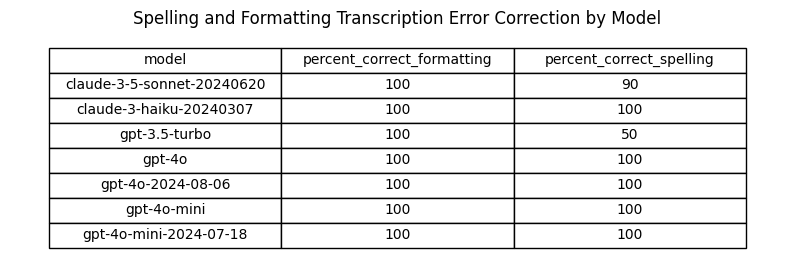

In [84]:
# Function to calculate whether the soap_plan includes the text 5/325
def check_formatting(soap_plan: str):
    return 1 if "5/325" in soap_plan else 0

# Function to calculate whether the soap_plan includes the text flexeril
def check_spelling(soap_plan: str):
    return 1 if "flexeril" in soap_plan.lower() else 0

# Add a new column to store whether soap_plan includes corrrect formatting of 5/325
df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

# Add a new column to store whether soap_plan includes corrected spelling of flexeril
df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

# Count the number of rows with correct formatting
corrected_formatting = df.groupby(['model'])['corrected_formatting'].sum().reset_index(name='corrected_formatting')

# Count the number of rows with correct formatting and calculate the percentage
corrected_formatting = df.groupby('model')['corrected_formatting'].agg(
    total_correct='sum',
    total_rows='count'
).reset_index()

# Calculate the percentage of rows with correct formatting
corrected_formatting['percent_correct_formatting'] = (
    (corrected_formatting['total_correct'] / corrected_formatting['total_rows']) * 100
).astype(int)

# Drop unnecessary columns if only the percentage is needed
corrected_formatting = corrected_formatting[['model', 'percent_correct_formatting']]

# Count the number of rows with correct spelling
corrected_spelling = df.groupby(['model'])['corrected_spelling'].agg(
    total_correct='sum',
    total_rows='count'
).reset_index()

# Calculate the percentage of rows with correct spelling
corrected_spelling['percent_correct_spelling'] = (
    (corrected_spelling['total_correct'] / corrected_spelling['total_rows']) * 100
).astype(int)

# Drop unnecessary columns if only the percentage is needed
corrected_spelling = corrected_spelling[['model', 'percent_correct_spelling']]


# Merge the results ()
grouped_output = pd.merge(corrected_formatting, corrected_spelling, on=['model'], how='inner')



# Plotting the table as an image
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust size to fit table
ax.axis('off')

# Set specific column widths (first column wider, others narrower)
col_widths = [0.3, 0.3, 0.3]  # Adjust these values as needed

table = ax.table(
    cellText=grouped_output.values,
    colLabels=grouped_output.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths,
)

ax.set_title('Spelling and Formatting Transcription Error Correction by Model')

table.auto_set_font_size(False)
table.scale(1, 1.5)

plt.show()

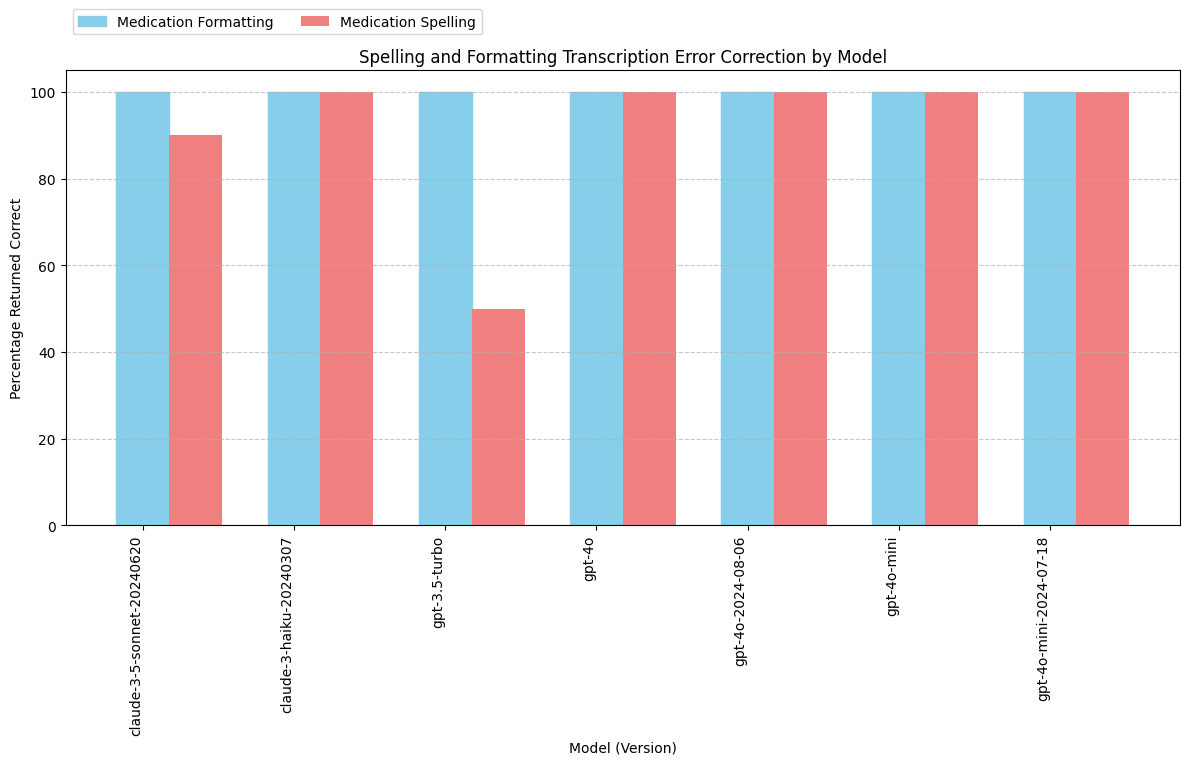

In [85]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
opacity = 0.8

# Bar chart for total corrected values
bar1 = ax1.bar(grouped_output['model'], grouped_output['percent_correct_formatting'], width=bar_width, label='Medication Formatting', color='skyblue', edgecolor='skyblue')
bar2 = ax1.bar([x + bar_width for x in range(len(grouped_output['model']))], grouped_output['percent_correct_spelling'], width=bar_width, label='Medication Spelling', color='lightcoral')

# Customizing the plot
ax1.set_xlabel('Model (Version)')
ax1.set_ylabel('Percentage Returned Correct')
ax1.set_title('Spelling and Formatting Transcription Error Correction by Model')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=90, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

#### **Conclusions: Fixing Transcription Errors**

- All models reliably fix the medication formatting error in the transcript.
- Except for claude-3-5-sonnet and gpt-3.5-turbo, all models are catching the spelling errors 100% of the time.
- Manual inspection of claude-3-5-sonnet and gpt-3.5-turbo predictions that did not catch spelling errors reveals unexpected behavior:
  - On the one occasion when claude-3-5-sonnet failed to correct the spelling of "flexor all" for "Flexeril," the model actually made the correction to "Cyclobenzaprine," which is the generic name for Flexeril.
  - On the five occasions when GPT-3.5-turbo failed to correct the spelling of "flexor all," the model actually omitted the medication from the note entirely. This error is far more concerning.



### **Model Comparisons**

In [89]:
# Define function to compare two models. Output results in a table

def calculate_model_differences(df: pd.DataFrame, model1: str, model2: str):
    df1 = df.loc[df['model'] == model1]
    df2 = df.loc[df['model'] == model2]
    total_rows1 = df1.groupby(['model']).size().reset_index(name='total_rows')
    total_rows2 = df2.groupby(['model']).size().reset_index(name='total_rows')

  # Prediction Costs
    avg_cost1 = df1['prediction_cost'].mean()
    avg_cost2 = df2['prediction_cost'].mean()
    absolute_difference_cost = avg_cost1 - avg_cost2
    relative_difference_cost = (absolute_difference_cost / avg_cost2) * 100

    # Output Tokens
    avg_output1 = round(df1['output_tokens'].mean())
    avg_output2 = round(df2['output_tokens'].mean())
    absolute_difference_output = avg_output1 - avg_output2
    relative_difference_output = (absolute_difference_output / avg_output2) * 100

    # Prediction Times
    avg_time1 = df1['prediction_time'].mean()
    avg_time2 = df2['prediction_time'].mean()
    absolute_difference_time = avg_time1 - avg_time2
    relative_difference_time = (absolute_difference_time / avg_time2) * 100 if avg_time1 != 0 else float('inf')  # Avoid division by zero

    # Differentials Calculations:
    # Function to calculate the length of differential diagnosis or zero if empty
    def diagnosis_length(diagnosis: str):
        return len(diagnosis) if diagnosis else 0

    df['differential_diagnosis'] = df['differential_diagnosis'].fillna('')

    # Add a new column for the length of differential diagnosis
    df['diff_diag_length'] = df['differential_diagnosis'].apply(diagnosis_length)

    # Count the number of rows with a non-empty differential diagnosis
    df['has_diff_diag'] = df['differential_diagnosis'].apply(lambda x: 1 if x else 0)

    # Check if 'alternative' is in the differential diagnosis
    df['has_alternative'] = df['differential_diagnosis'].apply(lambda x: 1 if 'alternative' in x.lower() else 0)

    # Calculate the average length of differential diagnosis
    avg_diff_length = df.groupby(['model'])['diff_diag_length'].mean().reset_index(name='avg_diff_length')

    # Count the number of rows with a non-empty differential diagnosis
    total_diff_diag = df.groupby(['model'])['has_diff_diag'].sum().reset_index(name='total_diff_diag')

    # Count the number of rows with 'alternative' in the differential diagnosis
    total_alternative = df.groupby(['model'])['has_alternative'].sum().reset_index(name='total_alternative')

    # Merge the results
    grouped_output = pd.merge(avg_diff_length, total_diff_diag, on=['model'])
    grouped_output = pd.merge(grouped_output, total_alternative, on=['model'])


    # Calculate the percentage of rows with 'alternative' in the differential diagnosis
    percent_with_alternative1 = grouped_output.loc[grouped_output['model'] == model1, 'total_alternative'].values[0] / grouped_output.loc[grouped_output['model'] == model1, 'total_diff_diag'].values[0] * 100
    percent_with_alternative2 = grouped_output.loc[grouped_output['model'] == model2, 'total_alternative'].values[0] / grouped_output.loc[grouped_output['model'] == model2, 'total_diff_diag'].values[0] * 100
    absolute_difference_alternative = percent_with_alternative1 - percent_with_alternative2
    relative_difference_alternative = (absolute_difference_alternative / percent_with_alternative2) * 100


    # Calculate differential diagnosis length difference
    differential_length1 = round(grouped_output.loc[grouped_output['model'] == model1, 'avg_diff_length'].values[0])
    differential_length2 = round(grouped_output.loc[grouped_output['model'] == model2, 'avg_diff_length'].values[0])
    absolute_difference_length = differential_length1 - differential_length2
    relative_difference_length = (absolute_difference_length / differential_length2) * 100


    # Function to calculate whether the soap_plan includes the text 5/325
    def check_formatting(soap_plan: str):
        return 1 if "5/325" in soap_plan else 0

    # Function to calculate whether the soap_plan includes the text flexeril
    def check_spelling(soap_plan: str):
        return 1 if "flexeril" in soap_plan.lower() else 0

    # Add a new column to store whether soap_plan includes corrrect formatting of 5/325
    df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

    # Add a new column to store whether soap_plan includes corrected spelling of flexeril
    df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

    # Count the number of rows with correct formatting
    total_formatted = df.groupby(['model'])['corrected_formatting'].sum().reset_index(name='total_formatted')

    # Count the number of rows with correct spelling
    total_spelling = df.groupby(['model'])['corrected_spelling'].sum().reset_index(name='total_spelling')

    # Merge the results ()
    grouped_output = pd.merge(total_formatted, total_spelling, on=['model'], how='inner')

    # Percentage of spelling errors fixed
    spelling_errors1 = grouped_output.loc[grouped_output['model'] == model1, 'total_spelling'].values[0] / df1['differential_diagnosis'].count() * 100
    spelling_errors2 = grouped_output.loc[grouped_output['model'] == model2, 'total_spelling'].values[0] / df2['differential_diagnosis'].count() * 100
    absolute_difference_spelling = spelling_errors1 - spelling_errors2
    relative_difference_spelling = (absolute_difference_spelling / spelling_errors2) * 100

    # Percentage of formatting errors fixed
    formatting_errors1 = grouped_output.loc[grouped_output['model'] == model1, 'total_formatted'].values[0] / df1['differential_diagnosis'].count() * 100
    formatting_errors2 = grouped_output.loc[grouped_output['model'] == model2, 'total_formatted'].values[0] / df2['differential_diagnosis'].count() * 100
    absolute_difference_formatting = formatting_errors1 - formatting_errors2
    relative_difference_formatting = (absolute_difference_formatting / formatting_errors2) * 100

    # Format the results

    results = pd.DataFrame({
        'Metric': ['Prediction Cost ($)', 'Output Tokens (#)', 'Prediction Time (s)', 'Fixed Spelling Errors (%)', 'Fixed Formatting Errors (%)', 'Include Alternative Treatment (%)', 'Differential Diagnosis Length (chars)'],
        f'{model1}': [f"{avg_cost1:.06f}", f"{avg_output1:.0f}", f"{avg_time1:.2f}", f"{spelling_errors1:.0f}%", f"{formatting_errors1:.0f}%", f"{percent_with_alternative1:.0f}%", f"{differential_length1}",],
        f'{model2}': [f"{avg_cost2:.06f}", f"{avg_output2:.0f}", f"{avg_time2:.2f}", f"{spelling_errors2:.0f}%", f"{formatting_errors2:.0f}%", f"{percent_with_alternative2:.0f}%", f"{differential_length2}"],
        'Absolute Difference': [f"{absolute_difference_cost:.06f}", absolute_difference_output, f"{absolute_difference_time:.2f}", f"{absolute_difference_spelling:.2f}", f"{absolute_difference_formatting:.2f}", f"{absolute_difference_alternative:.2f}", absolute_difference_length],
        'Relative Difference (%)': [relative_difference_cost, relative_difference_output, relative_difference_time, relative_difference_spelling, relative_difference_formatting, relative_difference_alternative, relative_difference_length]
    }).set_index("Metric")


    # Define formatting functions
    def format_six_decimals(value):
        return f"{value:.6f}"  # 6 decimal places

    def format_no_decimals(value):
        return f"{value:.0f}"  # No decimal places

    def format_two_decimals(value):
        return f"{value:.2f}%"  # 2 decimal places with percentage sign


# Apply formatting functions
    results['Relative Difference (%)'] = results['Relative Difference (%)'].apply(lambda x: f"{x:.0f}%" if isinstance(x, (int, float)) else x)

    # Plotting the table as an image
    fig, ax = plt.subplots(figsize=(9, 3))  # Adjust size to fit table
    ax.axis('off')
    table = ax.table(cellText=results.values, colLabels=results.columns, rowLabels=results.index, cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.scale(1, 1.5)

    ax.set_title(f'Model Comparison: {model1} vs {model2}')

    plt.show()






#### **gpt-4o-mini-2024-07-18 compared to gpt-4o-mini**


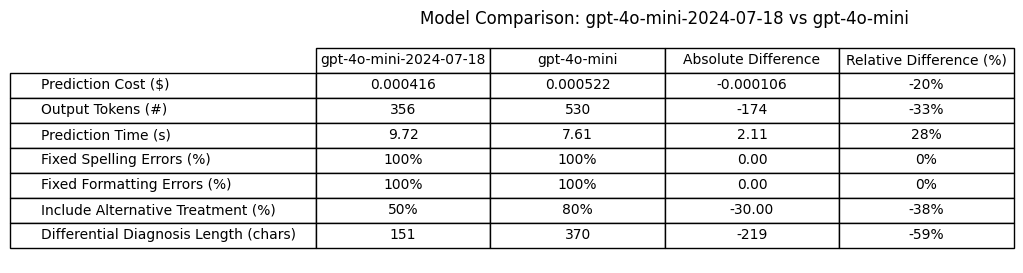

In [90]:
calculate_model_differences(df, 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini')

**Output Tokens:**
Less verbose (33% less output tokens)

**Cost:**
Better (20% cost reduction simply due to output reduction)

**Prediction times:**
Worse (2.11 seconds longer / 27.7% longer avg time)

**Fix Transcription Spelling Errors:**
Equal

**Fix Transcription Formatting Errors:**
Equal

**Include Alternative Treatment Plan with Differential:**
Worse (50% success rate compared to 80%)

**Length of Differential Diagnosis:**
Less verbose (59% shorter)

**Conclusion:**
- gpt-4o-mini-2024-07-18 is worse than gpt-4o-mini for this use case


#### **gpt-4o-2024-08-06 compared to gpt-4o**

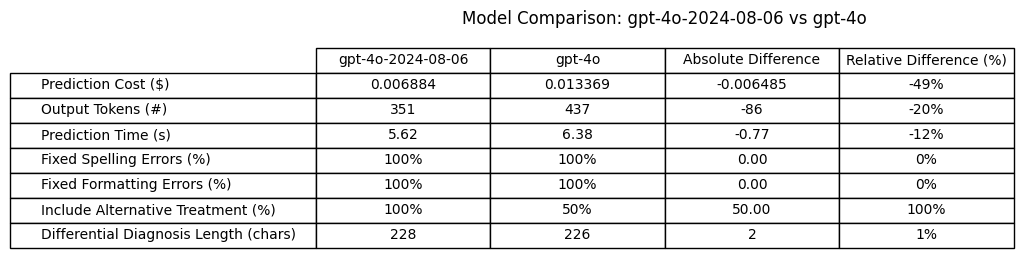

In [91]:
calculate_model_differences(df, 'gpt-4o-2024-08-06', 'gpt-4o')

**Output Tokens:**
Less verbose (20% less output tokens)

**Cost:**
Better (49% cost reduction due to price cut and output reduction)

**Prediction times:**
Better (0.77 seconds shorter / 12% shorter avg time)

**Fix Transcription Spelling Errors:**
Equal

**Fix Transcription Formatting Errors:**
Equal

**Include Alternative Treatment Plan with Differential:**
Better (100% success rate compared to 50%)

**Length of Differential Diagnosis:**
Equal

**Conclusion:**
- gpt-4o-2024-08-06 is better than gpt-4o for this use case


### **Overall Model Rankings by Criteria**


**Lowest cost:**
1. gpt-4o-mini
2. claude-3-haiku
3. gpt-3.5-turbo

**Inclusion of Alternative Treatment with Differential Diagnosis:**
1. claude-3.5-sonnet (long, very thorough)
2. gpt-3.5-turbo
3. gpt-4o-2024-08-06
- No other models scored 100%

**Fixing transcription errors:**
- All models 100% except claude-3.5-sonnet and gpt-3.5-turbo

**Quick, consistent prediction times:**
1. claude-3-haiku (reliably under 5 seconds)
2. gpt-3.5-turbo
3. gpt-4o-2024-08-06


#### **Takeaways**:
- gpt-4o-2024-08-06 is generally an improvement over gpt-4o. Perform more detailed analysis on output token reduction and what information might be dropped due to less verbose behavior.
- gpt-4o-mini-2024-07-18 is not a significant improvement over gpt-4o-mini for this use case.
- **Consider Switching Model to gpt-4o-2024-08-06:**
  - 100% reliability for including alternative treatment plan
  - Faster response time
  - More expensive model, but cost difference has reduced

### **Determine Implications of Switching To gpt-4o-2024-08-06 From gpt-4o-mini**
Compare model now under consideration (gpt-4o-2024-08-06) to model currently used in production (gpt-4o-mini) to understand implications of switching models.

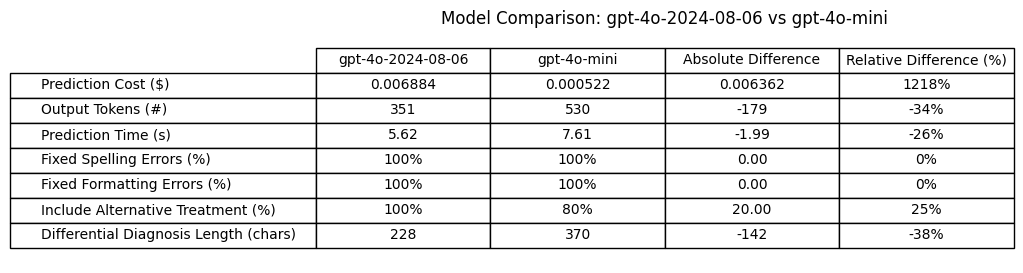

In [92]:
calculate_model_differences(df, 'gpt-4o-2024-08-06', 'gpt-4o-mini')

**Implications of switching to gpt-4o-2024-08-06 from gpt-4o-mini:**


**Cost:**
Worse (12 x the cost of gpt-4o-mini)

**Output Tokens:**
Less verbose (34% less output tokens)

**Prediction times:**
Better (2 seconds shorter / 26% shorter avg time)

**Fix Transcription Spelling Errors:**
Equal

**Fix Transcription Formatting Errors:**
Equal

**Include Alternative Treatment Plan with Differential:**
Better (100% success rate compared to 80%)

**Length of Differential Diagnosis:**
Less verbose (38% shorter)

**Conclusion:**
- If getting 100% inclusion of alternative treatment plans in the differential diagnosis and quicker response times would make a significant improvement for users of this application, gpt-4o-2024-08-06 could be a better model than gpt-4o-mini for this use case. However, changing the model may not be the only way to achieve this goal. It may be possible to get an alternative treatment included in the differential simply by updating the prompt.
  - Test separating alternative treatment plan into a separate required field on the JSON Schema to force a 100% successful inclusion rate for gpt-4o-mini.
- Note that switching over to gpt-4o-2024-08-06 from gpt-4o-mini will have a 12x increase on prediction costs.

**Recommendations:**
- Perform detailed review on differential diagnosis results from gpt-4o-2024-08-06 and gpt-4o-mini to understand what information, if any, is being left out in less verbose responses.

